# Candida/M. musculus peptide overlap

_PI: Simon Arthur (CSI)_

In [1]:
import os
import re
import hashlib
import pandas as pd
import seaborn as sns
from IPython.display import display,Markdown

pd.set_option('display.notebook_repr_html', True)


## Background

We would like to identify the number of shared peptides (from a trypsin digest) from mouse and candida. The mouse strain we normally use is C57BL/6J.  The Candida strain is SC5314; it seems to be the mouse common strain used and has been sequenced (http://www.candidagenome.org/).

## Source data

In [2]:
%%bash
mkdir data
cd data
#wget -nv ftp://ftp.ensembl.org/pub/release-94/fasta/mus_musculus/pep/Mus_musculus.GRCm38.pep.all.fa.gz
#gunzip -v Mus_musculus.GRCm38.pep.all.fa.gz

### Candida albicans SC5314

C. albicans SC5314 has also been sequenced and it's protein sequences were downloaded from Ensembl Genomes Relase 41 (22nd Nov 2018), which uses the Cand_albi_SC5314_V4 assembly. 

In [3]:
%%bash
cd data
wget -nv ftp://ftp.ensemblgenomes.org/pub/fungi/release-41/fasta/fungi_ascomycota2_collection/candida_albicans_sc5314_gca_000784635/pep/Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa.gz
gunzip -v Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa.gz

2023-03-28 15:56:54 URL: ftp://ftp.ensemblgenomes.org/pub/fungi/release-41/fasta/fungi_ascomycota2_collection/candida_albicans_sc5314_gca_000784635/pep/Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa.gz [2077375] -> "Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa.gz" [1]
Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa.gz:	   53.2% -- replaced with Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa


## Mouse UniProt database

The MM10 mouse genome assembly is derived from C57BL/J6. The proteins including all isoforms were data downloaded from UniProt 2023_01 via https://www.uniprot.org/uniprotkb?facets=model_organism%3A10090&query=reviewed%3Atrue.

In [4]:
%%bash
cd data
wget -nv -O uniprot_mouse.fa "https://rest.uniprot.org/uniprotkb/stream?download=true&format=fasta&includeIsoform=true&query=(reviewed%3Atrue)%20AND%20(model_organism%3A10090)"
cat uniprot_mouse.fa |sed -e 's/sp\|\([A-Z0-9\-]*\)\|[A-Z0-9_]*/\1/' > uniprot_mouse_2023_01.fa
rm uniprot_mouse.fa

2023-03-28 15:57:25 URL:https://rest.uniprot.org/uniprotkb/stream?download=true&format=fasta&includeIsoform=true&query=(reviewed%3Atrue)%20AND%20(model_organism%3A10090) [17884084] -> "uniprot_mouse.fa" [1]


## Trypsin digests

Various tools are available for carrying out _in-silico_ trypsin digests, including PeptideSeive, which takes into account frequency at which particular peptides are likely to be identified in MS based upon the proteins physiochemical properties. For the purposes of this exercise, a more simplistic basic trypsin digest is probably more appropriate. The EMBOSS 6.6.0.0 pepdigest tool can carry out trypsin digests, and by default does not cut proteins at unfavoured sites ('KR' followed by any of 'KRIFLP'). Trypsin digests are selected using the option '-menu 1', while it is also necessary to select whether to use monoisotopic weights or not for determination of peptide weights. These values are not relevant to the current analysis, consequently the setting used will not impact on the results. 

In [5]:
%%bash
cd data
pepdigest -auto -seqall uniprot_mouse_2023_01.fa -menu 1 -mono N -outfile uniprot_mouse_2023_01.pepdigest
pepdigest -auto -seqall Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa -menu 1 -mono N -outfile Candida_albicans.pepdigest

Pepdigest reports the digest products for each protein, along with some basic statistics for the peptide. The peptides have been parsed from these outputs using a python script, and stored in data structures allowing them to be interrogated. 

## Results

The total number of proteins and peptides represented, and also the proportion of proteins and peptides which are unique _within_ that organism are indicated in table 1. The unique proteins and peptides from each organism were then combined, and the unique numbers within this set also identified (labeled 'Combined unique peptides' in the table). The 'Unique proteins' and 'Unique peptides' values in this row indicate the proteins and peptides which are unique in the context of both organisms. 



In [6]:

def parse_pepdigest(digestfile): 
    
    new_seq_re = re.compile('# Sequence: ([\S]+)')
    peptide_re = re.compile('([\s]+[\d\.]+){3}[\s]+([A-Z\.][\s]+){2}([A-Z]+)')
    
    file = open(digestfile, 'r')
    prot_id=None
    pep_count=0
    peptides=[]
    
    for line in file:
        
        match = new_seq_re.match(line)
        if match:
            prot_id=match.group(1)
            pep_count=0
            
        match = peptide_re.match(line)
        if match:
            pep_count=pep_count+1
            peptide=match.group(3).encode('utf-8')
            md5sum=hashlib.md5(peptide).hexdigest()
            pep_data={
                'protein_id': prot_id,
                'count': pep_count,
                'peptide': peptide.decode('utf-8'),
                'md5sum': md5sum
            }
            peptides.append(pep_data)
        
    columns=['protein_id','count','peptide','md5sum']
    df = pd.DataFrame(peptides,columns=columns)
    # Some peptides are present multipe times, so determine the frequency of each peptide occurring   
    df['frequency']=df.groupby('peptide')['peptide'].transform('count')
    
    return df

# Identify protein and peptide counts for each organisms
organisms=['Candida_albicans','uniprot_mouse_2023_01']

total_dfs={}
high_freq_dfs={}
unique_dfs=[]
summary_data=[]
# dictionaries for storing per-organism lists of peptides for generating venn diagrams
peplists={}
peplists_unique={}
peplists_high_freq={}

for beast in organisms:
    
    df=parse_pepdigest('data/%s.pepdigest' % beast)
    unique_df=df.drop_duplicates('md5sum',keep=False)
    prots=df['protein_id'].unique().tolist()
    unique_prots=unique_df['protein_id'].unique().tolist()
    high_freq_df=df[df['frequency']>2]
    high_freq_df=high_freq_df.sort_values(by=['frequency'])
    
    peplists[beast]=df['peptide'].tolist()
    peplists_unique[beast]=unique_df['peptide'].tolist()
    peplists_high_freq[beast]=high_freq_df['peptide'].tolist()
    df=df.drop(columns=['md5sum'])
    
    total_dfs[beast]=df
    high_freq_dfs[beast]=high_freq_df
    
    protein_count=len(prots)
    peptide_count=(len(df.index))
    unique_protein_count=len(unique_prots)
    unique_peptide_count=(len(unique_df.index))
    
    unique_dfs.append(unique_df)
    
    data={
        'Category': beast,
        'Peptide count': peptide_count,
        'Protein count': protein_count,
        'Unique peptides': unique_peptide_count,
        'Unique proteins': unique_protein_count
    }
    summary_data.append(data)
    
# Combined values for both genomes
merged_df=pd.concat(unique_dfs)

merged_prots=merged_df['protein_id'].unique().tolist()
merged_peptide_count=(len(merged_df.index))
merged_protein_count=len(merged_prots)
unique_merged_df=merged_df.drop_duplicates('md5sum',keep=False)
unique_merged_prots=unique_merged_df['protein_id'].unique().tolist()
unique_merged_peptide_count=(len(unique_merged_df.index))
unique_merged_protein_count=(len(unique_merged_prots))

merged_data={
    'Category': 'Combined unique peptides',
    'Peptide count': merged_peptide_count,
    'Protein count': merged_protein_count,
    'Unique peptides': unique_merged_peptide_count,
    'Unique proteins': unique_merged_protein_count
}
summary_data.append(merged_data)

# Intersections between values for both genomes
duplicate_df=merged_df[merged_df.duplicated('peptide',keep=False)]
common_prots=duplicate_df['protein_id'].unique().tolist()
#common_proteins=(merged_protein_count-unique_merged_protein_count)/2
#common_peptides=(merged_peptide_count-unique_merged_peptide_count)/2
#common_data={
#    'Category': 'Common to both',
#    'Peptide count':'',
#    'Protein count':'',
#    'Unique peptides':common_peptides,
#    'Unique proteins': len(common_prots),
#}
#summary_data.append(common_data)


pd.set_option("display.latex.longtable", True)
summary_columns=['Category','Protein count','Peptide count','Unique proteins', 'Unique peptides']
summary_df=pd.DataFrame(summary_data,columns=summary_columns)
display(summary_df)

,Category,Protein count,Peptide count,Unique proteins,Unique peptides
0,Candida_albicans,6380,208558,6197,153141
1,uniprot_mouse_2023_01,25464,1103262,22820,352822
2,Combined unique peptides,29017,505963,29000,501365


*Table 1 - summary of protein and peptide counts*

The intersections of various sets of peptides are shown in figure 1. The subset of Candida albicans and Mus musculus peptides which are unique within each organism are indicated in plots (a) and (b). The intersection between the full set of peptides from each organisms is indicated in (c), while (d) illustrates the number of peptides within the unique set of peptides from each organism. 

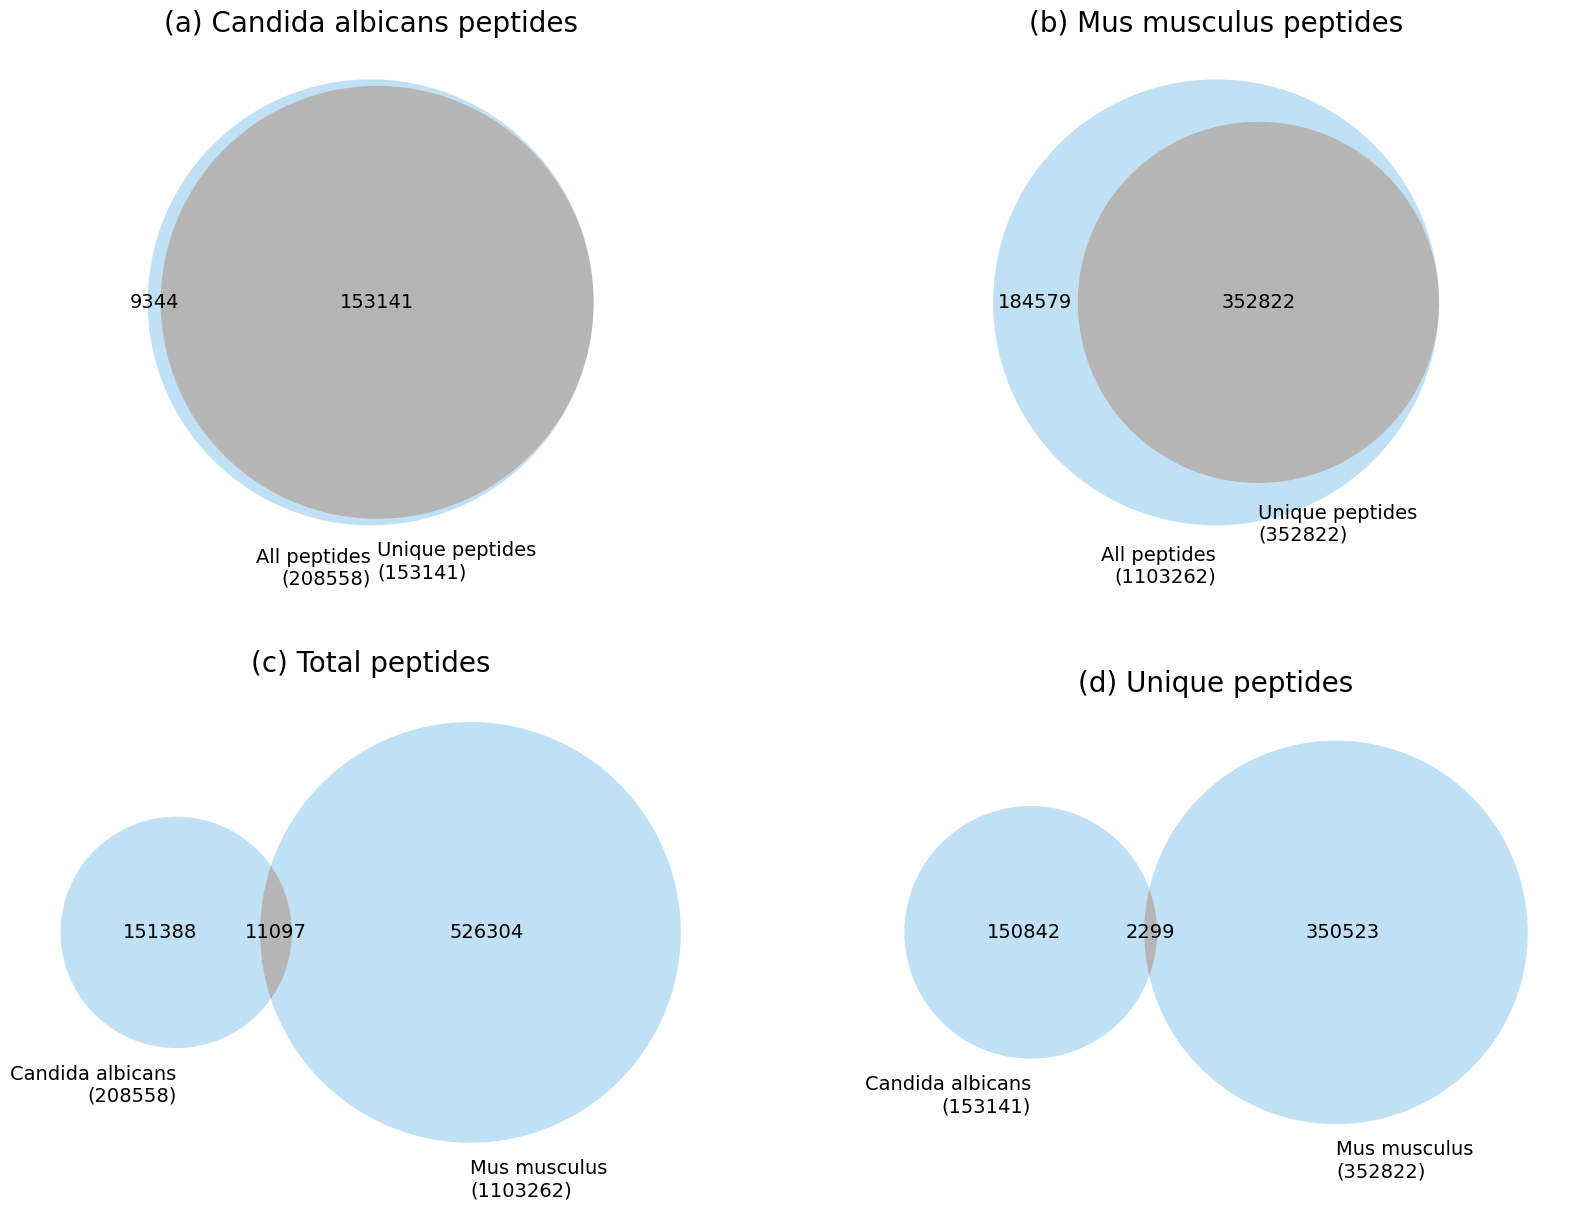

In [7]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2


plt.figure(figsize=(20, 15))
plt.subplot(221)

ca_pep=venn2(
        [set(peplists['Candida_albicans']),
         set(peplists_unique['Candida_albicans'])],
        set_labels=("All peptides\n(%s)" % len(peplists['Candida_albicans']),
                    "Unique peptides\n(%s)" % len(peplists_unique['Candida_albicans']))) 
plt.title('(a) Candida albicans peptides',fontsize=20)
for text in ca_pep.set_labels:
    text.set_fontsize(14)
for text in ca_pep.subset_labels:
    text.set_fontsize(14)
ca_pep.get_patch_by_id('01').set_color('#62b3e6')
ca_pep.get_patch_by_id('01').set_edgecolor('none')
ca_pep.get_patch_by_id('11').set_color('#464646')
ca_pep.get_patch_by_id('11').set_edgecolor('none')
ca_pep.get_patch_by_id('10').set_color('#62b3e6')
ca_pep.get_patch_by_id('10').set_edgecolor('none')
ca_pep.get_label_by_id('01').set_text('')
    
plt.subplot(222)
mm_pep=venn2(
        [set(peplists['uniprot_mouse_2023_01']),set(peplists_unique['uniprot_mouse_2023_01'] )],
        set_labels=("All peptides\n(%s)" % len(peplists['uniprot_mouse_2023_01']),
                    "Unique peptides\n(%s)" % len(peplists_unique['uniprot_mouse_2023_01']))
    )
plt.title('(b) Mus musculus peptides',fontsize=20)
for text in mm_pep.set_labels:
    text.set_fontsize(14)
for text in mm_pep.subset_labels:
    text.set_fontsize(14)
mm_pep.get_patch_by_id('01').set_color('#62b3e6')
mm_pep.get_patch_by_id('01').set_edgecolor('none')
mm_pep.get_patch_by_id('11').set_color('#464646')
mm_pep.get_patch_by_id('11').set_edgecolor('none')
mm_pep.get_patch_by_id('10').set_color('#62b3e6')
mm_pep.get_patch_by_id('10').set_edgecolor('none')
mm_pep.get_label_by_id('01').set_text('')
    
plt.subplot(223)
total=venn2(
        [set(peplists['Candida_albicans']),set(peplists['uniprot_mouse_2023_01'] )],
        set_labels=("Candida albicans\n(%s)" % len(peplists['Candida_albicans']),
                    "Mus musculus\n(%s)" % len(peplists['uniprot_mouse_2023_01']))
    )
plt.title('(c) Total peptides',fontsize=20)
for text in total.set_labels:
    text.set_fontsize(14)
for text in total.subset_labels:
    text.set_fontsize(14)
total.get_patch_by_id('01').set_color('#62b3e6')
total.get_patch_by_id('01').set_edgecolor('none')
total.get_patch_by_id('11').set_color('#464646')
total.get_patch_by_id('11').set_edgecolor('none')
total.get_patch_by_id('10').set_color('#62b3e6')
total.get_patch_by_id('10').set_edgecolor('none')

plt.subplot(224)
unique=venn2(
        [set(peplists_unique['Candida_albicans']),set(peplists_unique['uniprot_mouse_2023_01'])],
        set_labels=("Candida albicans\n(%s)" % len(peplists_unique['Candida_albicans']),
                    "Mus musculus\n(%s)" % len(peplists_unique['uniprot_mouse_2023_01']))
    )
plt.title('(d) Unique peptides',fontsize=20)
for text in unique.set_labels:
    text.set_fontsize(14)
for text in unique.subset_labels:
    text.set_fontsize(14)
unique.get_patch_by_id('01').set_color('#62b3e6')
unique.get_patch_by_id('01').set_edgecolor('none')
unique.get_patch_by_id('11').set_color('#464646')
unique.get_patch_by_id('11').set_edgecolor('none')
unique.get_patch_by_id('10').set_color('#62b3e6')
unique.get_patch_by_id('10').set_edgecolor('none')

mouse_prots=total_dfs['uniprot_mouse_2023_01']['protein_id'].tolist()
candida_prots=total_dfs['Candida_albicans']['protein_id'].tolist()
duplicate_df=merged_df[merged_df.duplicated('peptide',keep=False)]
common_prots=duplicate_df['protein_id'].unique().tolist()
                        
plt.show()

*Figure 1 - Intersections of various peptide sets. (a) Unique peptides within total set of Candida albicans peptides (b) Unique peptides within the total set of Mus musculus peptides (c) Total peptides of Candida albicans and Mus musculus (d) Unique peptides from Candida albicans and Mus musculus.*

Note there is a discrepancy between the total number of peptides and the sum of the unique and non-unique peptides sets in each organism. This is a result of non-unique peptides which are represented more than twice, which is particularly common for very short peptides. Density plots showing the frequency distribution of peptides in both organisms are shown in figure 2. 

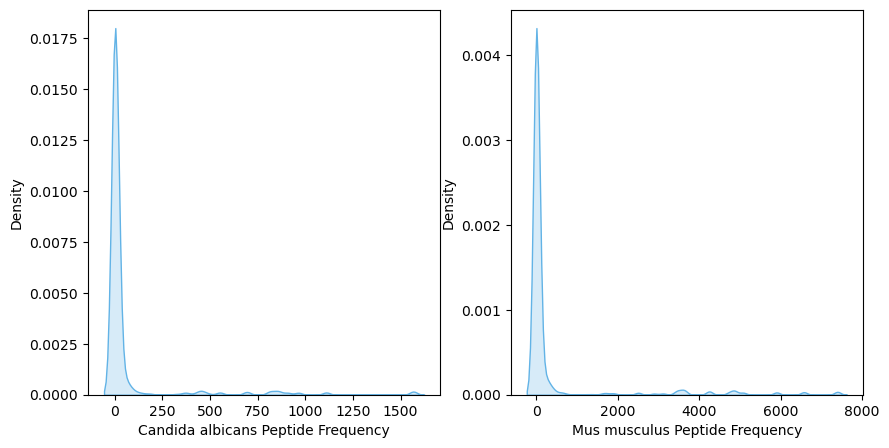

In [8]:
# import seaborn as sns
plot=plt.figure(figsize=(10, 5))
plt.subplot(121)
fig1=sns.kdeplot(total_dfs['Candida_albicans']['frequency'], fill=True,color='#62b3e6',legend=False)
fig1.set(xlabel='Candida albicans Peptide Frequency', ylabel='Density')
plt.subplot(122)
fig2=sns.kdeplot(total_dfs['uniprot_mouse_2023_01']['frequency'], fill=True,color='#62b3e6',legend=False)
fig2.set(xlabel='Mus musculus Peptide Frequency')
pass

*Figure 2 - Peptide frequency distribution of all peptides*

The 2299 peptides which are common between Candida and Mouse are found in 1945 Mouse proteins and 1719 Candida proteins. Summary tables of the proteins in the intersection are available in the tab-delimited `candida_intersection_proteins.txt` and `mouse_intersection_proteins.txt` files. To determine the likely impact on proteins which may be difficult to correctly identify due to a high proportion of shared peptides, the number of shared peptides and number of total peptides for each protein in this intersection was compared in proteins with more than one shared peptide. Proteins with >50% shared peptides are indicated in table 2. Only 1 protein would appear to be affected in this way. This protein (GBRG2_MOUSE) is annotated as Gamma-aminobutyric acid receptor subunit gamma-2. 685 proteins have more than one shared peptide, which are summarised in the file `shared_peptide_proportions.txt`

In [9]:
# Determine impact of shared peptides on potential protein identification
duplicate_df=merged_df[merged_df.duplicated('peptide',keep=False)]
common_prots=duplicate_df['protein_id'].unique().tolist()

multi_pep_common_prots=duplicate_df[duplicate_df.duplicated('protein_id',keep=False)]
multi_pep_common_prot_ids=set(multi_pep_common_prots['protein_id'])

shared_counts_50=[]
f=open('data/shared_peptide_proportions.txt', 'w')
f.write("Protein ID\tShared peptides\tTotal peptides\tPercentage shared\n")

for prot_id in multi_pep_common_prot_ids:
    common_peps=multi_pep_common_prots[multi_pep_common_prots['protein_id']==prot_id]
    common_pep_count=len(common_peps.index)
    total_peps=merged_df[merged_df['protein_id']==prot_id]
    total_pep_count=len(total_peps.index)
    shared_proportion=(common_pep_count/float(total_pep_count))*100
    shared_proportion_string=("%.2f%%" % shared_proportion)
    dat={
        'Protein ID':prot_id,
        'Shared peptides': common_pep_count,
        'Total peptides': total_pep_count,
        'Percentage shared': shared_proportion_string
    }
    f.write("%s\t%s\t%s\t%s\n" % (prot_id,common_pep_count,total_pep_count,shared_proportion_string))
    if (shared_proportion>50):
        shared_counts_50.append(dat)
    
columns=['Protein ID','Shared peptides','Total peptides','Percentage shared']
shared_count_df = pd.DataFrame(shared_counts_50,columns=columns)

display(shared_count_df)
display(Markdown('*Table 2 - Proteins with >50% shared peptides*'))

# Save proteins with common peptides as fasta file
from Bio import SeqIO
mouse_prots = SeqIO.to_dict(SeqIO.parse("data/uniprot_mouse_2023_01.fa", "fasta"))
candida_prots = SeqIO.to_dict(SeqIO.parse("data/Candida_albicans_sc5314_gca_000784635.Cand_albi_SC5314_V4.pep.all.fa", "fasta"))

mouse_prot_records=[]
candida_prot_records=[]

for prot in common_prots:
    if prot in mouse_prots:
        record=mouse_prots[prot]
        mouse_prot_records.append(record)
    else:
        record=candida_prots[prot]
        candida_prot_records.append(record)

SeqIO.write(mouse_prot_records, "data/mouse_intersection_proteins.fa", "fasta")
SeqIO.write(candida_prot_records, "data/candida_intersection_proteins.fa", "fasta")

# Output summary tables of affected proteins
f=open("data/mouse_intersection_proteins.txt", "w")
f.write("ID\tGene symbol\tDescription\n")
for mouse_prot in mouse_prot_records:
    id=mouse_prot.id
    desc=mouse_prot.description
    
    match=re.search('GN=([\S]+)',desc)
    if match:
       gene_symbol=match.group(1)
    match=re.search('[A-Z0-9-]* ([^$]+) OS=',desc)
    
    if match:
        description=match.group(1)
    else:
        print('no description in {}'.format(desc))
    
    f.write("%s\t%s\t%s\n" % (id,gene_symbol,description))
f.close()

f=open("data/candida_intersection_proteins.txt", "w")
f.write("ID\tGene symbol\tDescription\n")
for candida_prot in candida_prot_records:
    id=candida_prot.id
    desc=candida_prot.description
    
    match=re.search('gene:([\S]+)',desc)
    if match:
       gene_symbol=match.group(1)
    match=re.search('description:([^$]+)',desc)
    if match:
        description=match.group(1)
    
    f.write("%s\t%s\t%s\n" % (id,gene_symbol,description))
f.close()

,Protein ID,Shared peptides,Total peptides,Percentage shared
0,P22723,2,3,66.67%


*Table 2 - Proteins with >50% shared peptides*

## Summary

The overlap in peptides between Candida and mouse would result in certain peptides from 1945 mouse proteins and 1719 Candida being unable to be assigned unambiguously to a specific protein in either organism. This does not, however, mean that these proteins would not be able to be discriminated between by other peptides they contain, since in the vast majority of cases the proportion of unique peptides available within each organism is considerable. Only one protein was found to have >50% of it's peptides present in both organisms, so while individual peptides may be common between the organisms, this should not prevent the identification of most proteins.

Considerably more peptides are non-unique within each organism, and consequently would not allow discrimination between different proteins within each organism, than there are in the intersection between the organisms. Mouse, in particular, is notable for the proportion of non-unique peptides represented in the proteome. The originating organism and protein for the vast majority of peptides identified through MS proteomics experiments would therefore be able to be unambiguously identified.